# TP - Traitement d'images


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

### Question 2.a

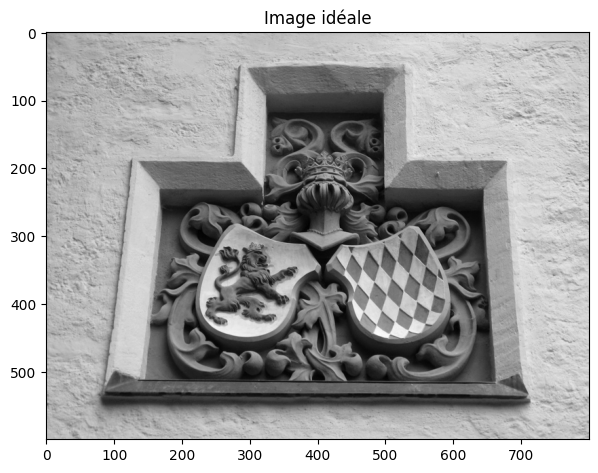

In [ ]:
#Chargement image
i_ideal = plt.imread('coat_of_arms.png')

#Affichage
plt.figure(figsize=(7,7))
plt.imshow(i_ideal, cmap='gray')
plt.title('Image idéale')
plt.show()

In [ ]:
#Filtre moyenneur
h = (1/400) * np.ones((20,20))

#On génère l'image i
img = signal.convolve2d(i_ideal, h, mode='same', boundary='wrap')

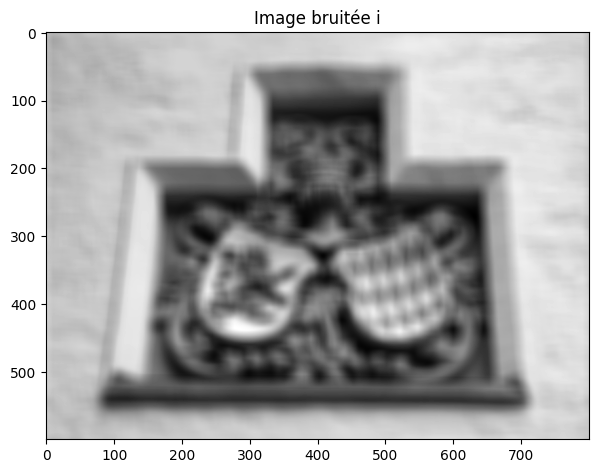

In [ ]:
#Affichage image bruitée
plt.figure(figsize=(7,7))
plt.imshow(img, cmap='gray')
plt.title('Image bruitée i')
plt.show()

### Question 2.b

In [ ]:
#Transformées de Fourier de nos objets
i_ideal_tf = np.fft.fft2(i_ideal)
img_tf = np.fft.fft2(img)
h_tf = np.fft.fft2(h, s=img.shape)

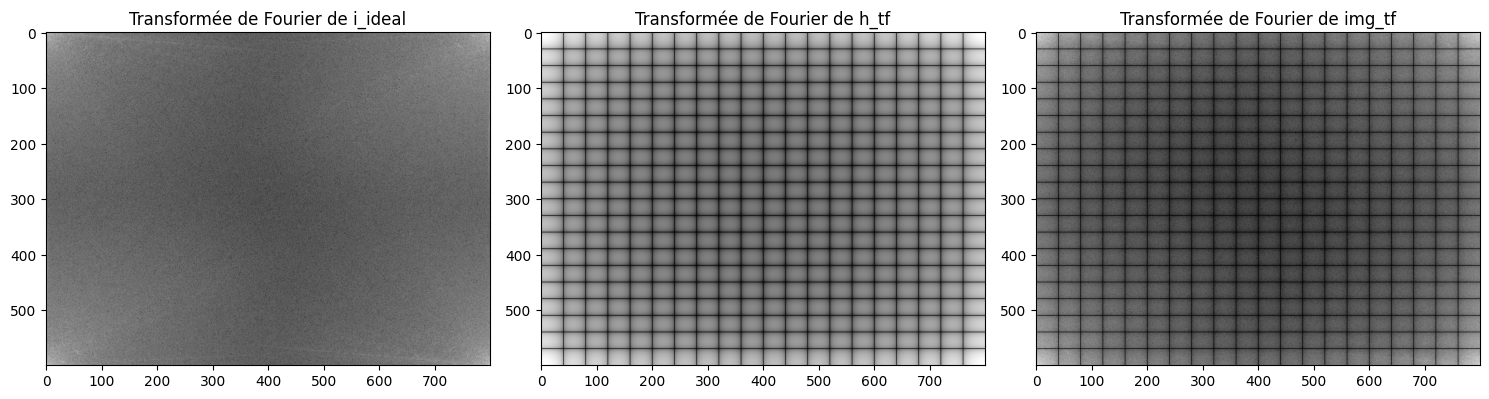

In [ ]:
#Affichages
axes = []
fig = plt.figure(figsize=(15,5))
titles = ['Transformée de Fourier de i_ideal', 'Transformée de Fourier de h_tf', 'Transformée de Fourier de img_tf']

for i, im in enumerate([i_ideal_tf, h_tf, img_tf]):
    axes.append(fig.add_subplot(1, 3, i+1) )
    subplot_title = titles[i]
    axes[-1].set_title(subplot_title)
    plt.imshow(np.log(abs(im) + 10**(-5)), cmap='gray')
fig.tight_layout()
plt.show()

### Question 2.c



<ipython-input-7-2160c6a2416d>:2: RuntimeWarning: divide by zero encountered in divide
  sol = np.divide(img_tf, h_tf)
<ipython-input-7-2160c6a2416d>:2: RuntimeWarning: invalid value encountered in divide
  sol = np.divide(img_tf, h_tf)


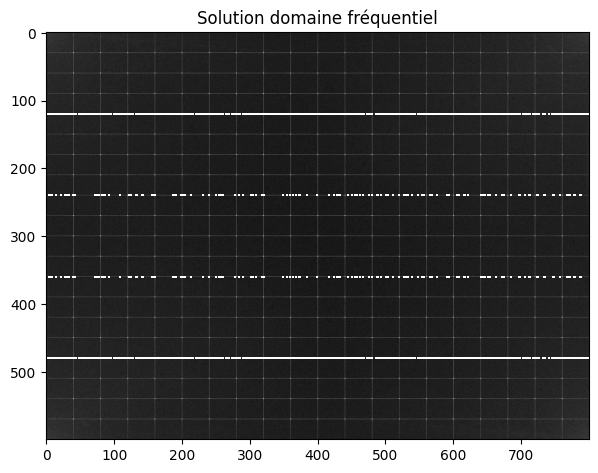

In [ ]:
#Application de la formule I/H
sol = np.divide(img_tf, h_tf)

#Affichage domaine fréquentiel
plt.figure(figsize=(7,7))
plt.imshow(np.log(abs(sol) + 10**(-5)), cmap='gray')
plt.title('Solution domaine fréquentiel')
plt.show()

> On fait des divisions par 0 avec cette méthode, car on divise par $H(u,v)$ sans se soucier de sa valeur.

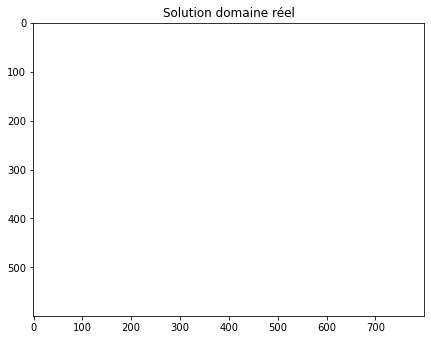

In [ ]:
sol_reelle = abs(np.fft.ifft2(sol))

#Affichage domaine réel
plt.figure(figsize=(7,7))
plt.imshow(sol_reelle, cmap='gray')
plt.title('Solution domaine réel')
plt.show()

> On n'obtient pas d'image au final, car nous n'avons pas obtenu une transformée de Fourier "complète" dans le domaine fréquentiel. Cela est dû aux divisions par 0 qui ont créées des NaN. Cette méthode n'est donc pas une bonne méthode.

### Question 2.d

In [ ]:
#Méthode avec seuillage
def methode_seuil(I, H, seuil):
  res = np.zeros_like(I)
  for i in range(len(I)):
    for j in range(len(I[0])):
      if abs(H[i,j])>=seuil:
        res[i,j] = I[i,j] / H[i,j]
      else:
        res[i,j] = I[i,j]
  return res

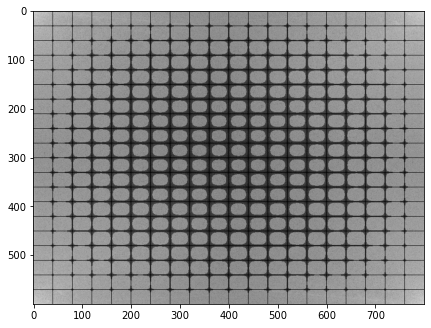

In [ ]:
sol = methode_seuil(img_tf, h_tf, 10**(-3))

#Affichage domaine fréquentiel
plt.figure(figsize=(7,7))
plt.imshow(np.log(abs(sol) + 10**(-5)), cmap='gray')
plt.show()

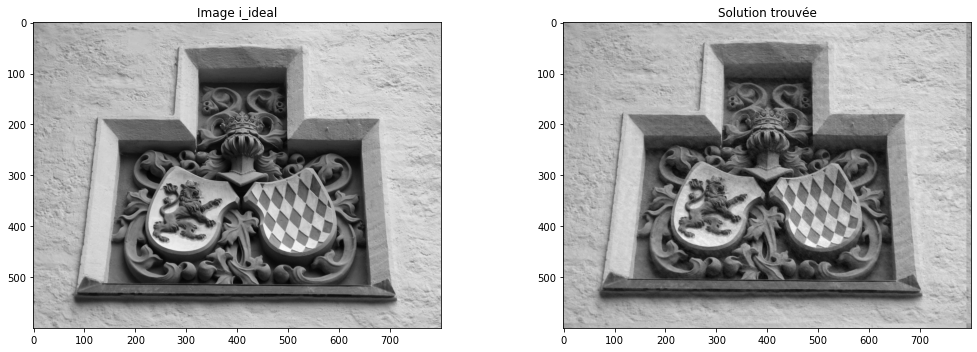

In [ ]:
sol_dom_reel = np.real(np.fft.ifft2(sol))

#Affichage domaine réel
axes = []
fig = plt.figure(figsize=(15,5))
titles = ['Image i_ideal', 'Solution trouvée']

for i, im in enumerate([i_ideal, sol_dom_reel]):
    axes.append(fig.add_subplot(1, 2, i+1) )
    subplot_title = titles[i]
    axes[-1].set_title(subplot_title)
    plt.imshow(im, cmap='gray')
fig.tight_layout()
plt.show()

>On a résolu le problème de divison par zéro en appliquant une méthode de seuil, lorsque $H(u,v)$ est plus petit en module que la valeur du seuil (qui est fixé assez proche de 0) on attribue au résultat la valeur de l'image bruitée. Sinon on peut appliquer la division dans le domaine fréquentiel.
>
>Cela nous permet d'obtenir une image solution assez propre et proche de $i_{ideal}$.
>
>On va calculer l'erreur entre l'image de base est l'image solution obtenue par la méthode du seuil.


In [ ]:
err = np.linalg.norm(i_ideal - sol_dom_reel)
print("L'erreur est entre l'image originale et la solution est = ", round(err, 2))

L'erreur est entre l'image originale et la solution est =  100.79


### Question 2.e

In [ ]:
#Implémentation du filtre de Wiener
def wiener(I, H, K):
  res = np.copy(I)
  res= (np.conj(H) / (np.abs(H)**2 + K)) * I
  res = np.abs(np.fft.ifft2(res))
  return res

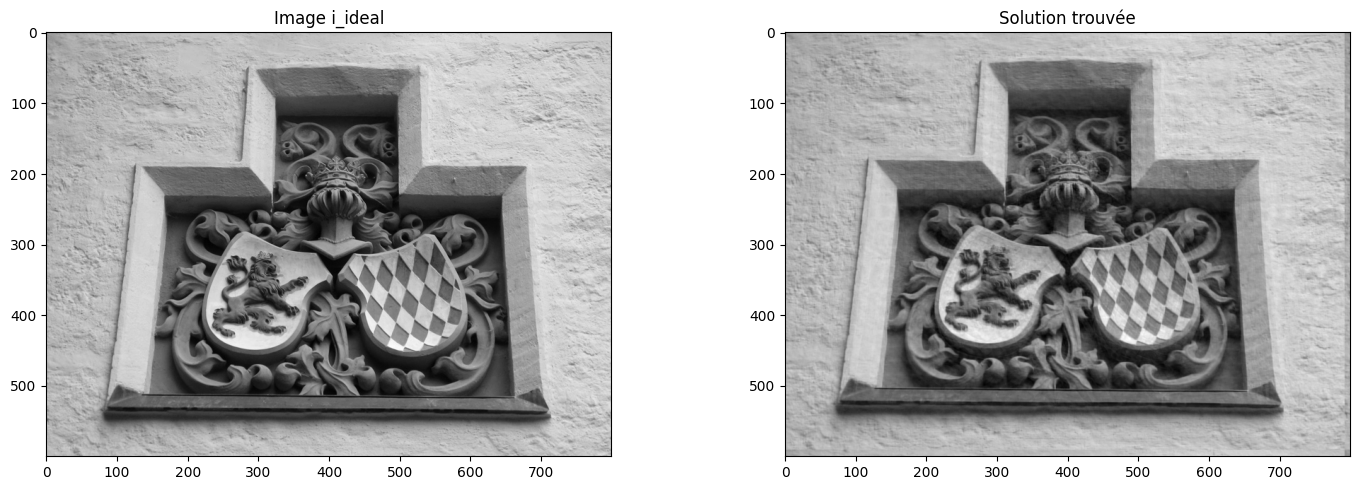

In [ ]:
#Test du filtre de Wiener
sol_wiener = wiener(img_tf, h_tf, 10**(-5))

#Affichage
axes = []
fig = plt.figure(figsize=(15,5))
titles = ['Image i_ideal', 'Solution trouvée']

for i, im in enumerate([i_ideal, sol_wiener]):
    axes.append(fig.add_subplot(1, 2, i+1) )
    subplot_title = titles[i]
    axes[-1].set_title(subplot_title)
    plt.imshow(im, cmap='gray')
fig.tight_layout()
plt.show()

In [ ]:
err_wiener = round(np.linalg.norm(i_ideal - sol_wiener), 2)
err_wiener

99.79

### Question 3

>On va maintenant condidérer le cas avec bruit gaussien.
>
>L'image doit être bruitée telle que sa puissance soit de $RSB_{dB} = 40dB$

In [ ]:
SNR = 40 #dB
P_im = np.sum(i_ideal**2) #puissance de l'image
P_b = P_im / (10**(SNR / 10)) #puissance du bruit

#On génère le bruit gaussien
b = np.random.normal(0, 1, i_ideal.shape) #bruit gaussien
b_norm = b / np.sqrt(np.sum(b**2)) * np.sqrt(P_b) #on normalise le bruit pour avoir la bonne puissance

#On génère l'image bruitée
img_bg = img + b_norm

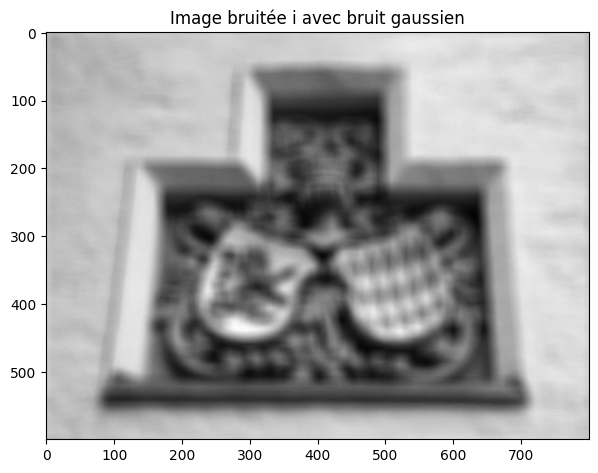

In [ ]:
#Affichage image bruitée
plt.figure(figsize=(7,7))
plt.imshow(img_bg, cmap='gray')
plt.title('Image bruitée i avec bruit gaussien')
plt.show()

In [ ]:
#Transfomée de Fourier de l'image bruitée et du bruit
img_bg_tf = np.fft.fft2(img_bg)
b_tf = np.fft.fft2(b_norm)

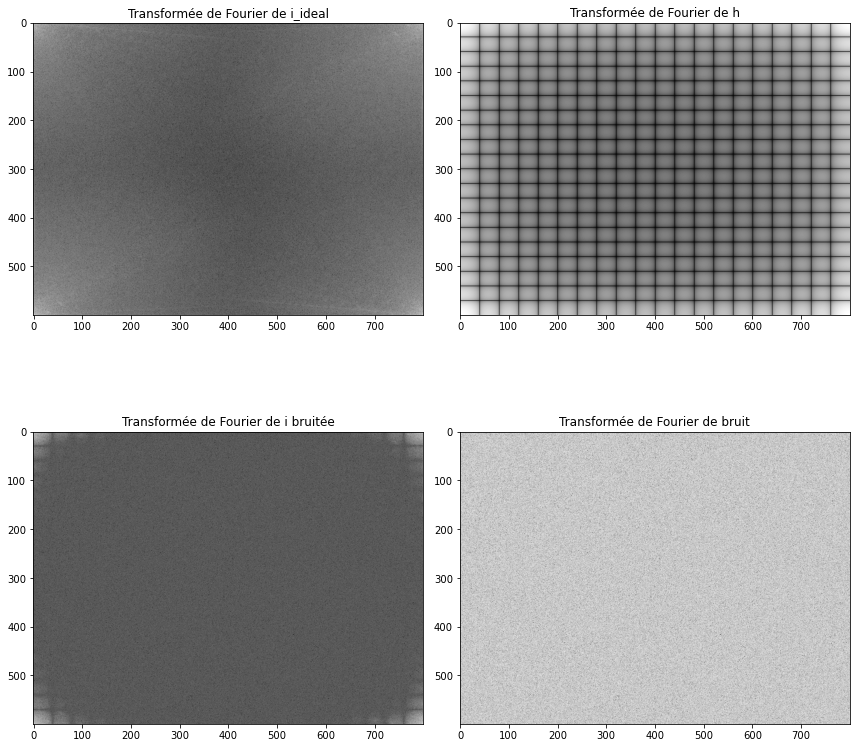

In [ ]:
#Affichages dans le domaine fréquentiel
axes = []
fig = plt.figure(figsize=(12,12))
titles = ['Transformée de Fourier de i_ideal', 'Transformée de Fourier de h', 'Transformée de Fourier de i bruitée', 'Transformée de Fourier de bruit']

for i, im in enumerate([i_ideal_tf, h_tf, img_bg_tf, b_tf]):
    axes.append(fig.add_subplot(2, 2, i+1) )
    subplot_title = titles[i]
    axes[-1].set_title(subplot_title)
    plt.imshow(np.log(abs(im) + 10**(-5)), cmap='gray')
fig.tight_layout()
plt.show()

C:\Users\chloe\AppData\Local\Temp\ipykernel_58884\928080905.py:2: RuntimeWarning: divide by zero encountered in true_divide
  sol = np.divide(img_bg_tf, h_tf)


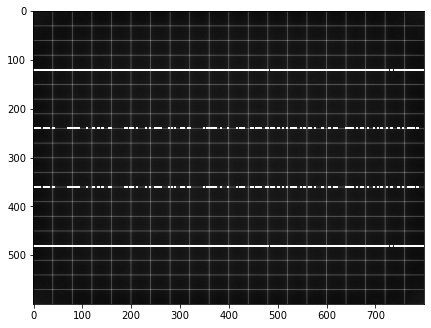

In [ ]:
#Application de la formule I/H
sol = np.divide(img_bg_tf, h_tf)

#Affichage domaine fréquentiel
plt.figure(figsize=(7,7))
plt.imshow(np.log(abs(sol) + 10**(-5)), cmap='gray')
plt.show()

>Même chose que dans le cas de l'image bruitée précédente. On fait des divisions par 0 avec cette méthode, car on divise par $H(u,v)$ sans se soucier de sa valeur.

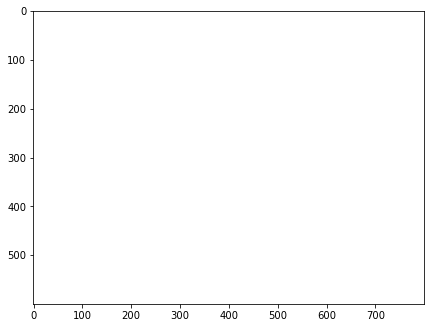

In [ ]:
sol_reelle = abs(np.fft.ifft2(sol))

#Affichage domaine réel
plt.figure(figsize=(7,7))
plt.imshow(sol_reelle, cmap='gray')
plt.show()

> On n'obtient pas d'image au final, car les divisions par 0 au calcul de la transformée de Fourier nous ont donné des NaN.

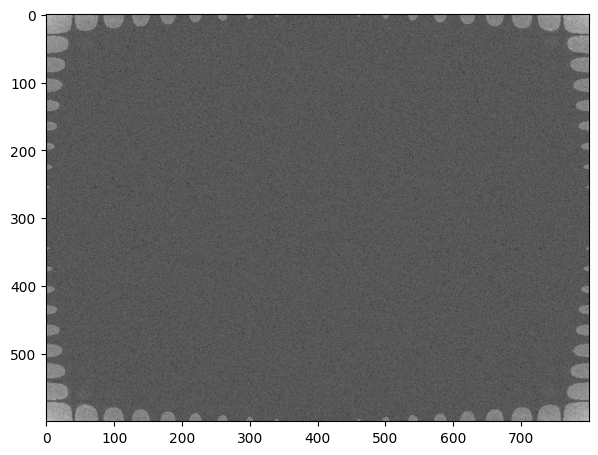

In [ ]:
sol = methode_seuil(img_bg_tf, h_tf, 0.05)

#Affichage domaine fréquentiel
plt.figure(figsize=(7,7))
plt.imshow(np.log(abs(sol) + 10**(-5)), cmap='gray')
plt.show()

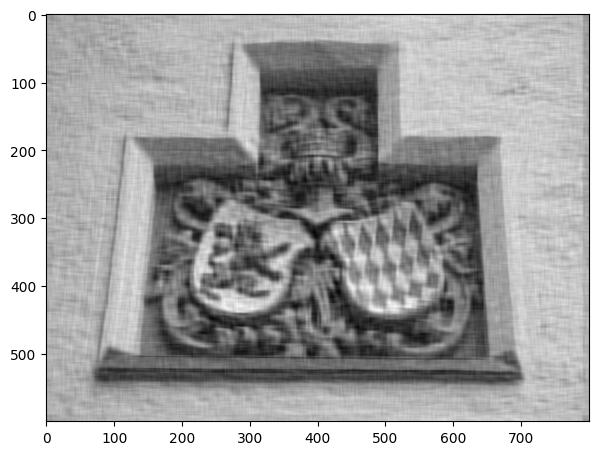

In [ ]:
#Affichage domaine réel
sol_dom_reel = np.real(np.fft.ifft2(sol))
plt.figure(figsize=(7,7))
plt.imshow(sol_dom_reel, cmap='gray')
plt.show()

In [ ]:
err = np.linalg.norm(i_ideal - sol_dom_reel)
print("L'erreur est entre l'image originale et la solution est = ", round(err, 2))

L'erreur est entre l'image originale et la solution est =  97.53


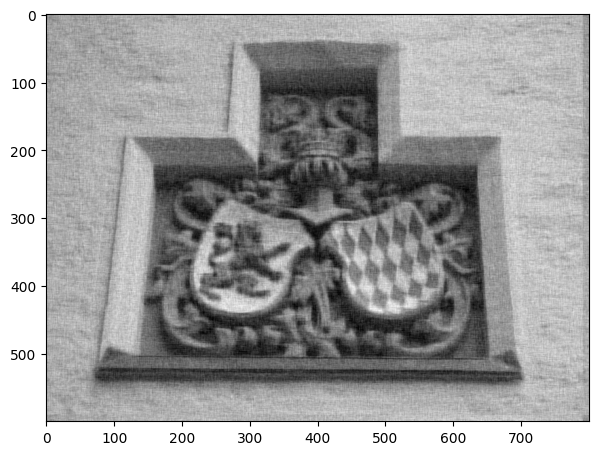

In [ ]:
#Test du filtre de Wiener
sol_wiener = wiener(img_bg_tf, h_tf, 10**(-3))

#Affichage
plt.figure(figsize=(7,7))
plt.imshow(sol_wiener, cmap='gray')
plt.show()

In [ ]:
err_wiener = round(np.linalg.norm(i_ideal - sol_wiener), 2)
print("L'erreur est entre l'image originale et la solution est = ", round(err_wiener, 2))

L'erreur est entre l'image originale et la solution est =  99.77
